 Для начала импортирую необходимые библиотеки. В данной работе я буду использовать алгоритм классификации CatBoostClassifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
import re

Загружаю тренировочный датасет

In [2]:
df_train = pd.read_csv("train.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Изучаю распределение данных с помощью построения визуализаций

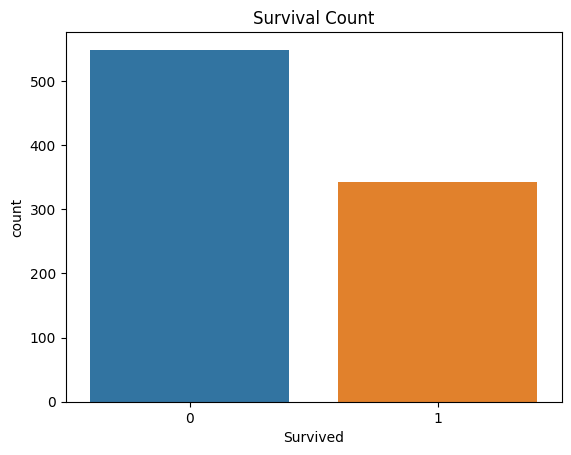

In [4]:
sns.countplot(x='Survived', data=df_train)
plt.title('Survival Count')
plt.show()

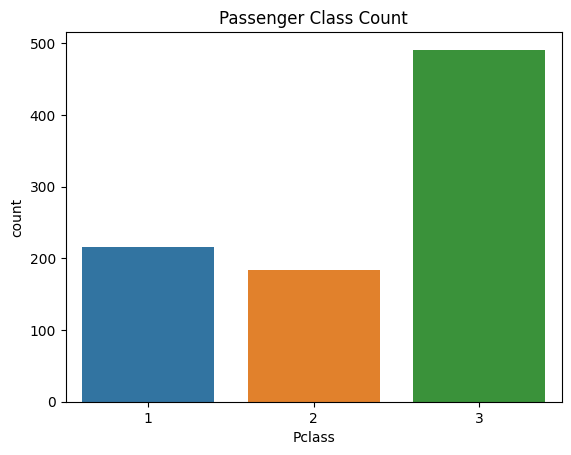

In [5]:
sns.countplot(x='Pclass', data=df_train)
plt.title('Passenger Class Count')
plt.show()

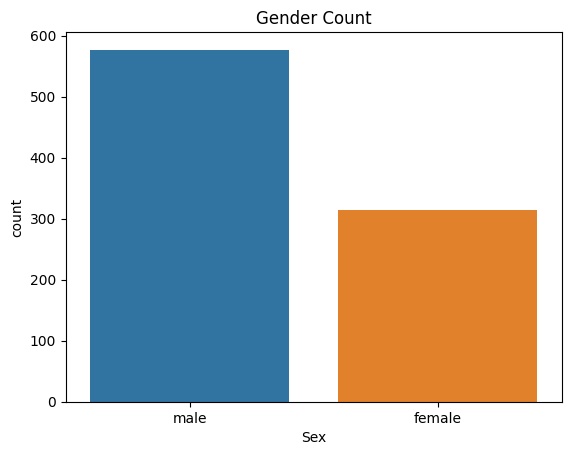

In [6]:
sns.countplot(x='Sex', data=df_train)
plt.title('Gender Count')
plt.show()

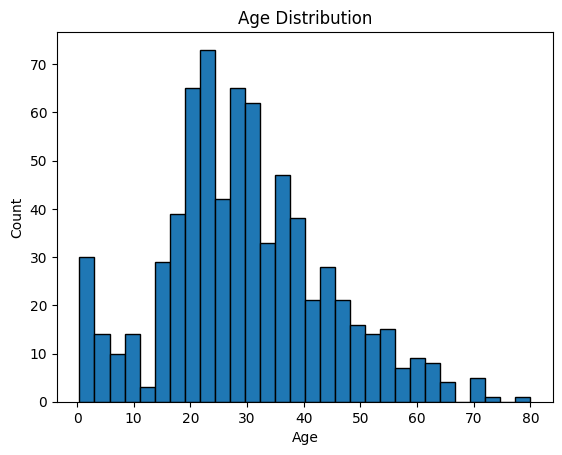

In [7]:
plt.hist(df_train['Age'].dropna(), bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Работа с пропусками

Заполняю пропуски в столбце Age медианным значением.
Также заполняю пропуски в столбце Embarked модой.



In [8]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df_train['Age'].fillna(28, inplace=True)
df_train['Embarked'].fillna('S', inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Feature engineering

Для начала извлекаю информацию из столбца Name. Можно заметить, что в каждом имени есть титул: Mr, Mrs, Dr и т.д. С помощью регулярного выражения вычленяю все титулы и логически объединяю их в несколько категорий

In [10]:
def substrings(gen_string):
	matches = set()
	regex_pattern = r'[A-Za-z]+\.'
	for string in gen_string:
		matches.add(' '.join(re.findall(regex_pattern, string)).replace('.', ''))
	return matches

titles_train = list(substrings(df_train['Name']))
titles_train

['Mr',
 'Dr',
 'Major',
 'Master',
 'Don',
 'Mrs L',
 'Capt',
 'Countess',
 'Jonkheer',
 'Rev',
 'Lady',
 'Mlle',
 'Ms',
 'Sir',
 'Miss',
 'Mme',
 'Mrs',
 'Col']

In [11]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

df_train['Title']=df_train['Name'].map(lambda x: substrings_in_string(x, titles_train))
df_train['Title'].value_counts()

Title
Mr          647
Miss        179
Master       40
Dr            8
Rev           6
Major         2
Col           2
Don           1
Mme           1
Ms            1
Mlle          1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

Изучив значения титулов в интернете, я решил выделить 4 основных категории:

1. Mr - сюда я отнес титулы Mr, Dr(в случае, если пассажир - мужчина), а также другие малочисленные группы титулов, относящихся к мужчинам.

2. Miss - так как наблюдается явное разделение женщин на 2 основные группы - Miss и Mrs, я решил оставить их, распределив оставшиеся малочисленные женские титулы по этим двум категориям. Сюда я отнёс титул Ms (Miss), а также, так как титул Miss имеют незамужние женщины, сюда же я отнес женщин с титулом Mlle(Mademoiselle), который обычно употребляют в отношении молодых девушек.

3. Mrs - этот титул употребляют в отношении замужних женщин, поэтому сюда я, помимо собственно титула Mrs, субъективно, отнёс титул Countess(Графиня), Mme(Мадам), Lady(Леди) и Dr(в случае, если пассажир - женщина)

4. Master - В связи с тем, что данный титул имеют большое количество человек, я решил выделить его в отдельную категорию

In [12]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
df_train['Title']=df_train.apply(replace_titles, axis=1)
df_train['Title'].value_counts()

Title
Mr        660
Miss      181
Master     40
Mrs        10
Name: count, dtype: int64

Объеденяю столбцы SibSp(Siblings + Spouses, братья и сестры + супруги) и Parch(Parents + Children, Родители + дети) в один столбец Family_Size, так как, думаю, влияние этих групп родственников на целевую переменную равнозначно

In [13]:
df_train['Family_Size']=df_train['SibSp']+df_train['Parch']

Буква в начале номера каюты в столбце Cabin, очевидно, означает какой-то класс каюты и их можно объединить по этим буквам. Извлекаю эти буквы и группирую по ним каюты, путем создания нового столбца Cabin_letter. Пропущенные значения заменяю на 'unknown', чтобы с ними можно было работать в дальнейшем

In [14]:
df_train['Cabin_Letter'] = df_train['Cabin'].str[:1]
df_train.Cabin_Letter.fillna('Unknown', inplace=True)

Наконец, остался столбец Ticket. Я подумал, что, так как у многих пассажиров на борту есть родственники, возможно, некоторые билеты куплены сразу на несколько пассажиров

In [15]:
df_train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Чтобы извлечь информацию из столбца Ticket, я создаю новый столбец, в котором для каждого пассажира будет указано общее количество пассажиров, проезжающих по тому же билету

In [16]:
tickets_train = df_train.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets_train.head()

,Count
Ticket,
110152,3
110413,3
110465,2
110564,1
110813,1


In [17]:
df_train['Group_Size']=df_train['Ticket'].apply(lambda x: tickets_train.loc[x, 'Count'])

Удаляю столбцы Name, Cabin и Ticket, так как я извлек из них нужную информацию и они больше не нужны 

In [18]:
df_train.drop(columns=['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,Cabin_Letter,Group_Size
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,1,Unknown,1
1,2,1,1,female,38.0,1,0,71.2833,C,Mr,1,C,1
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,0,Unknown,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mr,1,C,2
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,0,Unknown,1


Разделяю данные на признаки для обучения и целевую переменную

In [19]:
X = df_train.drop(columns=['PassengerId', 'Survived'], axis=1)
y = df_train['Survived']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Создаю объект класса Pool для обучения модели CatBoostClassifier

In [21]:
pool = Pool(X, label=y,
                  cat_features=['Sex', 'Embarked', 'Title', 'Cabin_Letter'])

Обучаю модель в первом приближении

In [22]:
model_1 = CatBoostClassifier(learning_rate=0.1, iterations=200, depth=8, eval_metric='AUC:hints=skip_train~false', random_seed=42)
model_1.fit(pool,
				eval_set=(X_val, y_val),
            verbose=False,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
metrics.roc_auc_score(y_val, model_1.predict(X_val))

0.9018661518661518

С помощью встроенной функции grid_search подбираю глобальные параметры и провожу кросс-валидацию

In [ ]:
model_2 = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', verbose=False)

grid_params = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
               'iterations': [50, 100, 200, 500, 1000],
					'depth': [2, 4, 6, 8, 10]}


grid_search_result = model_2.grid_search(grid_params,
                                         pool,
                                         verbose=False,
                                         plot=True
                                         )

In [ ]:
grid_search_result['params']

{'depth': 8, 'iterations': 50, 'learning_rate': 0.5}

Визуализирую значимость параметров для созданной модели

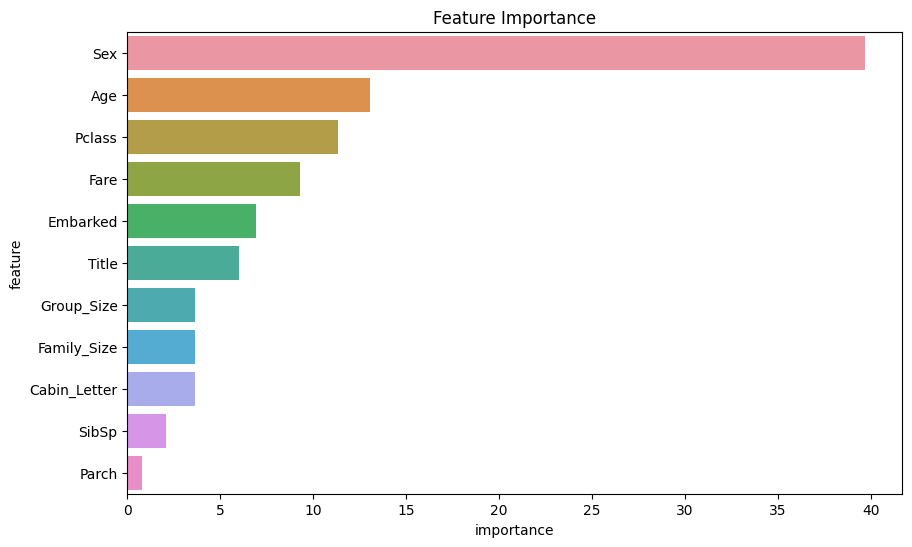

In [ ]:
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp',
					 'Parch', 'Fare', 'Embarked', 'Title',
					 'Family_Size', 'Cabin_Letter', 'Group_Size']

importances = model_2.feature_importances_

importances_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='importance', y='feature', orient='h')
plt.title('Feature Importance')
plt.show()

Загружаем тестовый датасет и подготавливаем его для проверки качества модели

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [ ]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [ ]:
df_test['Age'].fillna(27, inplace=True)
df_test['Fare'].fillna(14.454200, inplace=True)

Обращаюсь к функции substrings, чтобы вычленить титулы в тестовом датасете найти титулы, которых не было в тренировочном датасете, если такие есть

In [ ]:
titles_test = list(substrings(df_test['Name']))
[item for item in titles_test if item not in set(titles_train)]

['Dona']

In [ ]:
df_test['Title']=df_test['Name'].map(lambda x: substrings_in_string(x, titles_test))
df_test['Title'].value_counts()

Title
Mr        306
Miss       78
Master     20
Col         5
Dr          5
Rev         2
Ms          1
Dona        1
Name: count, dtype: int64

Согласно найденной информации, Dona - титул, который дают женам дворян, следовательно, я отнесу его в группу титулов Mrs

In [ ]:
def replace_titles_test(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
df_test['Title']=df_test.apply(replace_titles_test, axis=1)
df_test['Title'].value_counts()

Title
Mr        313
Miss       79
Master     20
Mrs         6
Name: count, dtype: int64

In [ ]:
df_test['Family_Size']=df_test['SibSp']+df_test['Parch']

In [ ]:
df_test['Cabin_Letter'] = df_test['Cabin'].str[:1]
df_test.Cabin_Letter.fillna('Unknown', inplace=True)

In [ ]:
df_test['Cabin_Letter'].value_counts()

Cabin_Letter
Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: count, dtype: int64

In [ ]:
tickets_test = df_test.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets_test.head()

,Count
Ticket,
110469,1
110489,1
110813,1
111163,1
112051,1


In [ ]:
df_test['Group_Size']=df_test['Ticket'].apply(lambda x: tickets_test.loc[x, 'Count'])

In [ ]:
df_test.drop(columns=['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,Cabin_Letter,Group_Size
0,892,3,male,34.5,0,0,7.8292,Q,Mr,0,Unknown,1
1,893,3,female,47.0,1,0,7.0000,S,Mr,1,Unknown,1
2,894,2,male,62.0,0,0,9.6875,Q,Mr,0,Unknown,1
3,895,3,male,27.0,0,0,8.6625,S,Mr,0,Unknown,1
4,896,3,female,22.0,1,1,12.2875,S,Mr,2,Unknown,1


Делаем предсказание и отправляем его на Kaggle.com

In [ ]:
df_test['Survived'] = model_1.predict(df_test.drop(columns='PassengerId', axis=1))

In [ ]:
df_test['Survived'] = model_2.predict(df_test.drop(columns='PassengerId', axis=1))
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,Cabin_Letter,Group_Size,Survived
0,892,3,male,34.5,0,0,7.8292,Q,Mr,0,Unknown,1,0
1,893,3,female,47.0,1,0,7.0000,S,Mr,1,Unknown,1,0
2,894,2,male,62.0,0,0,9.6875,Q,Mr,0,Unknown,1,0
3,895,3,male,27.0,0,0,8.6625,S,Mr,0,Unknown,1,0
4,896,3,female,22.0,1,1,12.2875,S,Mr,2,Unknown,1,1


In [ ]:
df_test['Survived'].value_counts()

Survived
0    275
1    143
Name: count, dtype: int64

In [ ]:
submission = df_test[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)

Score = 0.77511